### Protein Analyzer Notebook
 

### Introduction
This is a notebook which explores the possibility of creating new protein structures using a graph variational autoencoder (GVAE) model. The model is trained on a dataset of protein structures and then used to generate new protein structures. The notebook is divided into the following sections:

### Import Necessary Libraries

(210, 9)
        X        Y       Z AA   Avg_Mass   Avg_Neighbor_Dist  \
0  23.388  -19.139  -9.239  M  149.20784  3.8486709594726562   
1  24.634  -16.649  -6.582  K  146.18934   3.834369659423828   
2  23.024  -14.147  -4.186  A   89.09404  3.7685012817382812   
3  19.519  -14.167  -2.949  F  165.19184  3.7678961753845215   
4  20.762  -13.862   0.649  T  119.12034  3.8312950134277344   

    Max_Neighbor_Dist Neighbor_Count  AA_encoded  
0  3.8486709594726562            1.0           9  
1  3.8486709594726562            2.0           7  
2   3.820068120956421            2.0           0  
3  3.8188579082489014            2.0           3  
4  3.8437318801879883            2.0          15  
Number of nodes: 210
Number of edges: 534
Node features shape: torch.Size([210, 8])


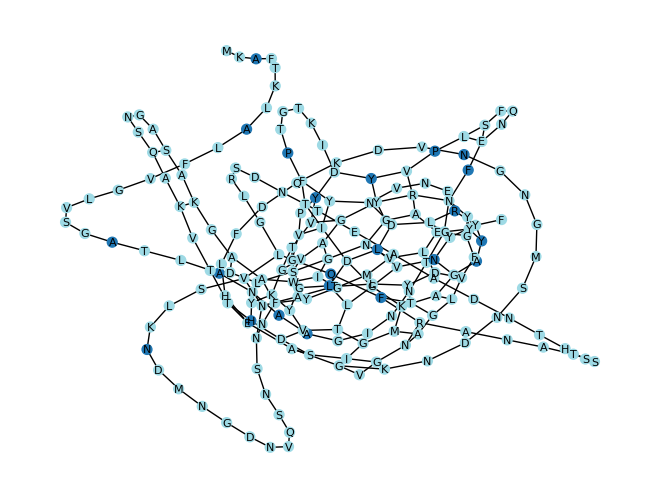

In [1]:
# Import necessary libraries
import os
import pandas as pd

from ProteinAnalyzer import ProteinAnalyzer
from GraphCreatorOneHotEncodedVariant import GraphCreatorOneHotEncodedVariant
from GraphCreator import GraphCreator
from Utils import Utils
import torch
from torch_geometric.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn as nn
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.optim as optim
from torch_geometric.data import Data
import numpy as np




### Variables for the notebook

In [2]:
# Variables for the notebook

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the file for a demo protein structure
pdb_file = '/Users/alexchilton/Downloads/archive/train/AF-D0ZA02-F1-model_v4.pdb'

# Define the directory containing the PDB files
pdb_directory = '/Users/alexchilton/Downloads/archive/just10000'

# Define the file containing amino acid information
aa_info_file = 'aa_mass_letter.csv'

### Load a Demo Protein Structure

(210, 9)
        X        Y       Z AA   Avg_Mass   Avg_Neighbor_Dist  \
0  23.388  -19.139  -9.239  M  149.20784  3.8486709594726562   
1  24.634  -16.649  -6.582  K  146.18934   3.834369659423828   
2  23.024  -14.147  -4.186  A   89.09404  3.7685012817382812   
3  19.519  -14.167  -2.949  F  165.19184  3.7678961753845215   
4  20.762  -13.862   0.649  T  119.12034  3.8312950134277344   

    Max_Neighbor_Dist Neighbor_Count  AA_encoded  
0  3.8486709594726562            1.0           9  
1  3.8486709594726562            2.0           7  
2   3.820068120956421            2.0           0  
3  3.8188579082489014            2.0           3  
4  3.8437318801879883            2.0          15  
Number of nodes: 210
Number of edges: 534
Node features shape: torch.Size([210, 8])


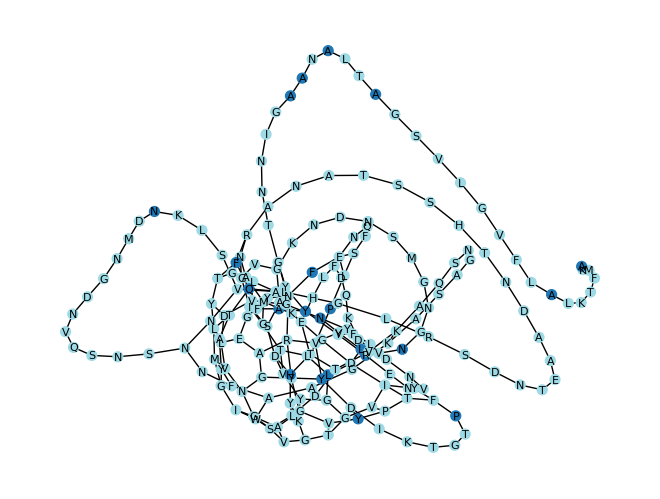

In [3]:
# Create the ProteinAnalyzer and GraphCreator objects
analyzer = ProteinAnalyzer(pdb_file, aa_info_file)
graph_creator = GraphCreator(pdb_file, aa_info_file)

# Generate the autoencoder input DataFrame  
autoencoder_input_df = analyzer.prepare_autoencoder_input()

autoencoder_input_df, le = graph_creator.encode_aa(autoencoder_input_df)
pd.set_option('display.max_columns', None)

print(autoencoder_input_df.shape)
print(autoencoder_input_df.head())

# Unpack the returned tuple
graph = graph_creator.create_graph(autoencoder_input_df)

# Print graph metrics
graph_creator.print_graph_metrics(graph)

# Draw the graph
graph_creator.draw_graph(graph, le)

### Load PDB Files 
and convert all to dfs which have our desired columns

In [4]:

def load_pdb_files(directory):
    ''' Load all PDB files from the specified directory '''
    pdb_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.pdb')]
    return pdb_files

def create_autoencoder_input_dfs(pdb_files, aa_info_file):
    ''' Create autoencoder input DataFrames for all PDB files '''
    autoencoder_input_dfs = []
    for pdb_file in pdb_files:
        analyzer = ProteinAnalyzer(pdb_file, aa_info_file)
        autoencoder_input_df = analyzer.prepare_autoencoder_input()
        autoencoder_input_dfs.append(autoencoder_input_df)
    return autoencoder_input_dfs


# Load PDB files
pdb_files = load_pdb_files(pdb_directory)

# Create autoencoder input DataFrames
autoencoder_input_dfs = create_autoencoder_input_dfs(pdb_files, aa_info_file)


### Convert Object Types to Float
and print the types and a head example

In [5]:
from Utils import Utils
# Assuming autoencoder_input_dfs is already defined convert the onject types to float
autoencoder_input_dfs = Utils.convert_columns_to_float(autoencoder_input_dfs)

# Verify the conversion
print(autoencoder_input_dfs[0].dtypes)
print(autoencoder_input_dfs[0].head())

X                    float64
Y                    float64
Z                    float64
AA                    object
Avg_Mass             float64
Avg_Neighbor_Dist    float64
Max_Neighbor_Dist    float64
Neighbor_Count       float64
dtype: object
        X       Y      Z AA   Avg_Mass  Avg_Neighbor_Dist  Max_Neighbor_Dist  \
0 -20.246  16.002 -8.805  M  149.20784           3.808177           3.808177   
1 -18.503  12.625 -9.050  A   89.09404           3.824629           3.841081   
2 -20.207   9.839 -7.028  S  105.09344           3.855387           3.869693   
3 -18.856   9.181 -3.462  P  115.13194           3.856041           3.869693   
4 -17.236   5.959 -4.788  L  131.17464           4.212434           4.940235   

   Neighbor_Count  
0             1.0  
1             2.0  
2             2.0  
3             2.0  
4             3.0  


### One Hot Encode the Data

In [6]:

from Utils import Utils
# Assuming autoencoder_input_dfs is already defined
onehot_encoder = Utils.create_onehot_encoder(autoencoder_input_dfs)

encoded_autoencoder_input_dfs = [Utils.encode_values(df, onehot_encoder) for df in autoencoder_input_dfs]
#decoded_autoencoder_input_dfs = [decode_values(df) for df in new_autoencoder_input_dfs]

# Print the first few rows of the first encoded and decoded DataFrame
print(encoded_autoencoder_input_dfs[0].head())
#print(decoded_autoencoder_input_dfs[0].head())

        X       Y      Z   Avg_Mass  Avg_Neighbor_Dist  Max_Neighbor_Dist  \
0 -20.246  16.002 -8.805  149.20784           3.808177           3.808177   
1 -18.503  12.625 -9.050   89.09404           3.824629           3.841081   
2 -20.207   9.839 -7.028  105.09344           3.855387           3.869693   
3 -18.856   9.181 -3.462  115.13194           3.856041           3.869693   
4 -17.236   5.959 -4.788  131.17464           4.212434           4.940235   

   Neighbor_Count  AA_A  AA_C  AA_D  AA_E  AA_F  AA_G  AA_H  AA_I  AA_K  AA_L  \
0             1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1             2.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
2             2.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3             2.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4             3.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   1.0   

   AA_M  AA_N  AA_P  AA_Q  AA_R  AA_S  AA_T  AA_V 

### Create Graphs from Encoded DataFrames

In [7]:
from GraphCreatorOneHotEncodedVariant import GraphCreatorOneHotEncodedVariant
graph_creator = GraphCreatorOneHotEncodedVariant()
graphs = []
for df in encoded_autoencoder_input_dfs:
    graph = graph_creator.create_graph(df)
    graphs.append(graph)

#### ONLY NORMALISE AFTER DOING THE EDGES!!! here would be ok...(should be done??)

### Print the First Few Graphs

Graph 1: 90 nodes, 216 edges


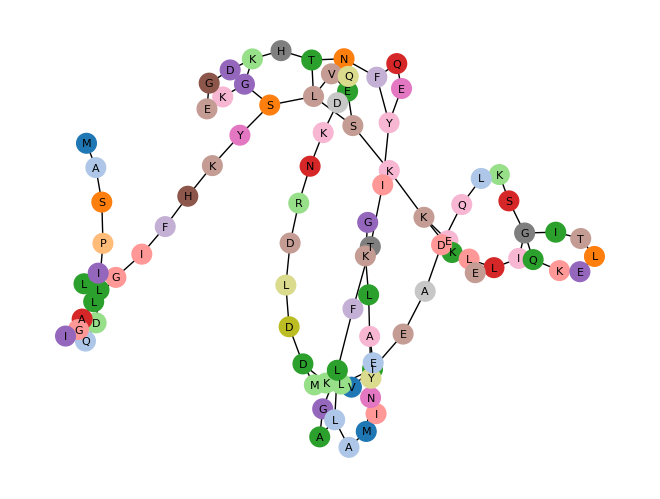

Graph 2: 113 nodes, 250 edges


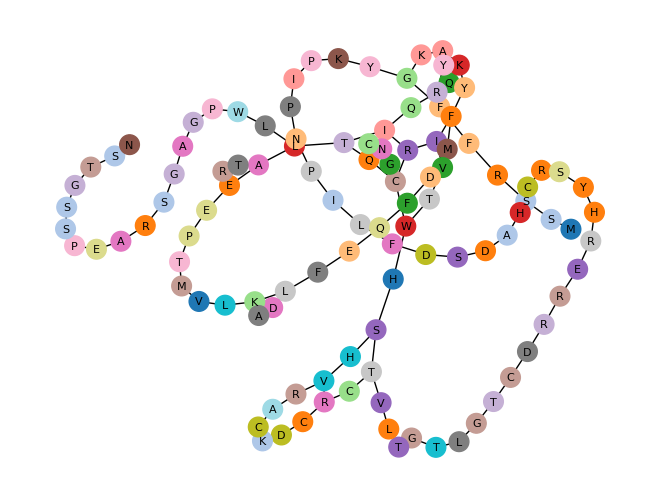

Graph 3: 23 nodes, 44 edges


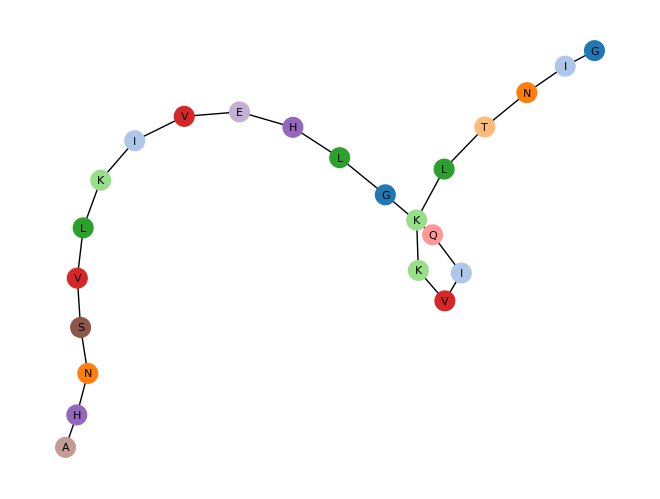

Graph 4: 130 nodes, 318 edges


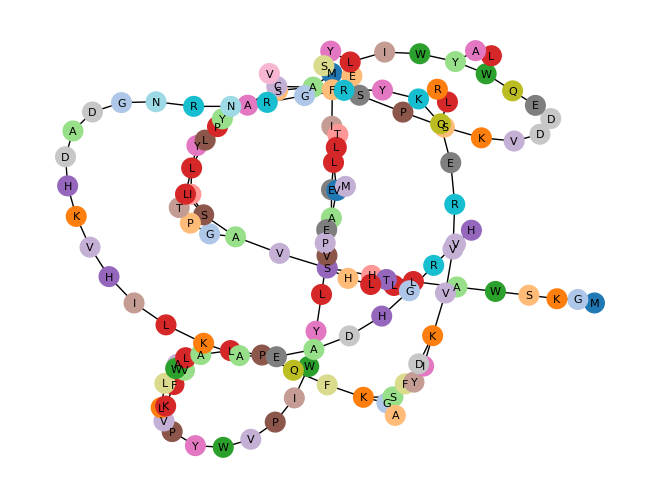

Graph 5: 66 nodes, 148 edges


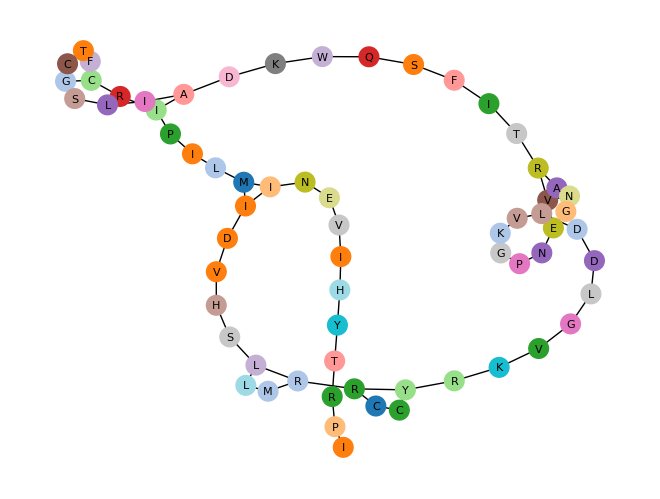

Graph 6: 119 nodes, 276 edges


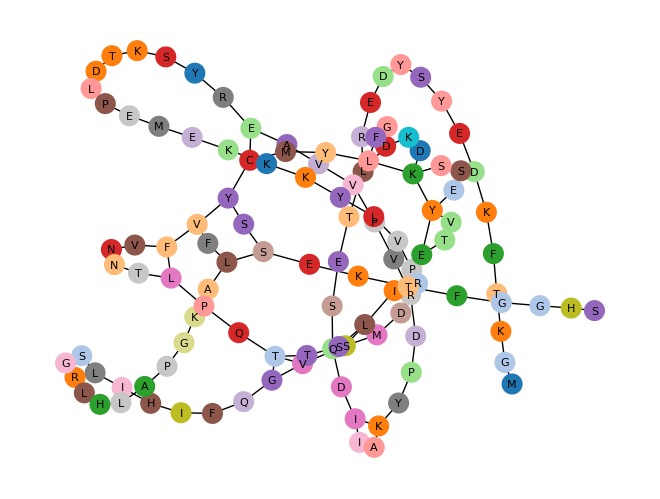

Graph 7: 128 nodes, 284 edges


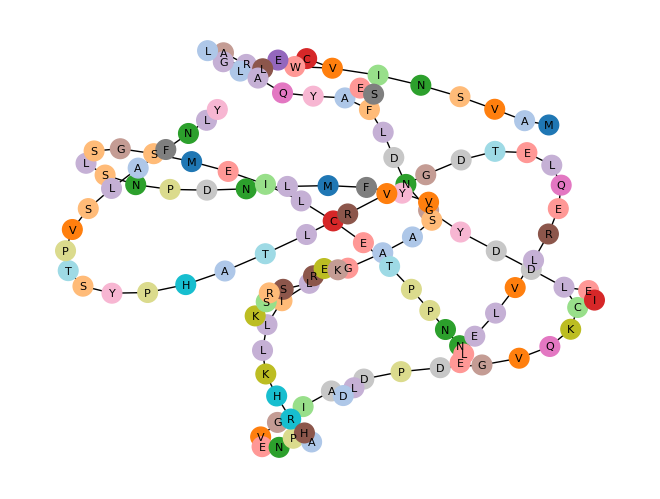

Graph 8: 143 nodes, 354 edges


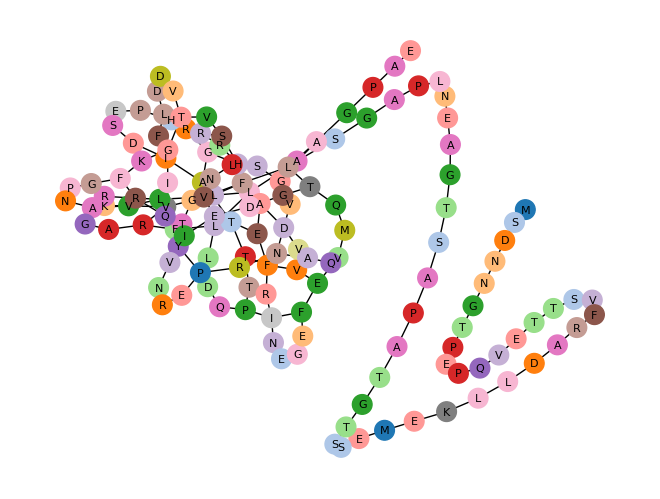

Graph 9: 105 nodes, 252 edges


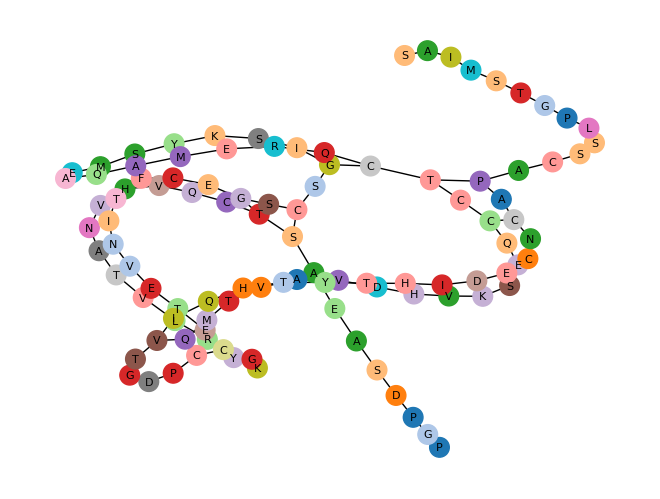

Graph 10: 137 nodes, 322 edges


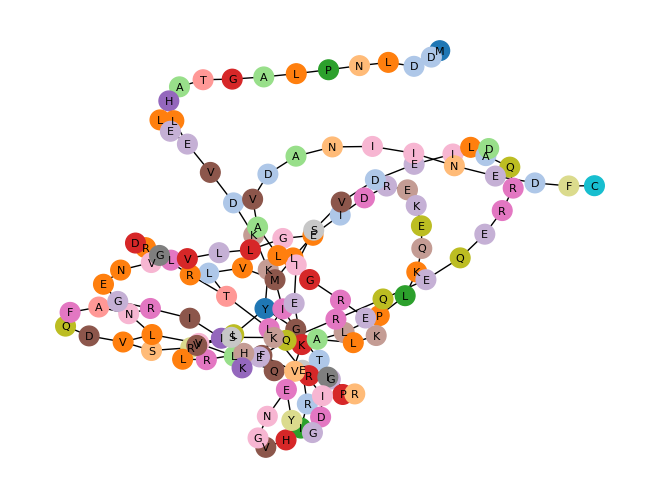

In [8]:
# Now `graphs` contains all the graphs created from the encoded DataFrames
for i, graph in enumerate(graphs[:10]):
    print(f"Graph {i + 1}: {graph.num_nodes} nodes, {graph.num_edges} edges")
    graph_creator.draw_graph(graph, onehot_encoder)

### Pad Graphs to Have the Same Number of Nodes

In [9]:
# Determine the maximum number of nodes in the dataset
max_num_nodes = max(graph.num_nodes for graph in graphs)

# Pad all graphs to have the same number of nodes
padded_graphs = graph_creator.pad_graphs(graphs, max_num_nodes)

# Now `padded_graphs` contains all the graphs with the same number of nodes and padded `AA_encoded` column

### Print the First Padded Graph and see that the padding has been done

In [10]:
graph_creator.print_first_graph(padded_graphs)

Node 1: tensor([-20.2460,  16.0020,  -8.8050, 149.2078,   3.8082,   3.8082,   1.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   1.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000])
Node 2: tensor([-18.5030,  12.6250,  -9.0500,  89.0940,   3.8246,   3.8411,   2.0000,
          1.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000])
Node 3: tensor([-20.2070,   9.8390,  -7.0280, 105.0934,   3.8554,   3.8697,   2.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   1.0000,   0.0000,   0.0000,   0.0000,   0.0000])
Node 4: tensor([-18.8560,   9.1810,  -3.4620, 115.1319,   3.8560,  

In [11]:
# Print the number of nodes and edges in each padded graph
graph_creator.print_graphCollection_metrics(padded_graphs)
# Print the number of graphs in the padded_graphs list
print(f"Number of graphs in padded_graphs: {len(padded_graphs)}")

Graph 1: 164 nodes, 216 edges, 27 features
Graph 2: 164 nodes, 250 edges, 27 features
Graph 3: 164 nodes, 44 edges, 27 features
Graph 4: 164 nodes, 318 edges, 27 features
Graph 5: 164 nodes, 148 edges, 27 features
Graph 6: 164 nodes, 276 edges, 27 features
Graph 7: 164 nodes, 284 edges, 27 features
Graph 8: 164 nodes, 354 edges, 27 features
Graph 9: 164 nodes, 252 edges, 27 features
Graph 10: 164 nodes, 322 edges, 27 features
Number of graphs in padded_graphs: 5000


### Define the Graph Variational Autoencoder Model

In [12]:
class GraphVAE(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_nodes):
        super(GraphVAE, self).__init__()
        self.num_nodes = num_nodes
        self.in_channels = in_channels
        self.encoder = nn.Sequential(
            GCNConv(in_channels, hidden_channels),
            nn.ReLU(),
            GCNConv(hidden_channels, hidden_channels),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_channels, out_channels)
        self.fc_logvar = nn.Linear(hidden_channels, out_channels)
        self.decoder = nn.Sequential(
            nn.Linear(out_channels, hidden_channels),
            nn.ReLU(),
            nn.Linear(hidden_channels, in_channels * num_nodes)  # Output size matches the fixed number of nodes
        )

    def encode(self, x, edge_index, batch):
        x = self.encoder[0](x, edge_index)
        x = self.encoder[1](x)
        x = self.encoder[2](x, edge_index)
        x = self.encoder[3](x)
        x = global_mean_pool(x, batch)  # Pooling to get graph-level embedding
        return self.fc_mu(x), self.fc_logvar(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std).to(mu.device)  # Ensure `eps` is on the same device
        return mu + eps * std

    def decode(self, z):
        recon = self.decoder(z)
        recon = recon.view(-1, self.num_nodes, self.in_channels)  # Reshape to (batch_size, num_nodes, in_channels)
        return recon

    def forward(self, x, edge_index, batch):
        mu, logvar = self.encode(x, edge_index, batch)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar



### Prepare the Graph Variational Autoencoder Model

In [13]:
# Assume `padded_graphs` is your list of padded graphs
dataset = padded_graphs

# Create a DataLoader for batching the graphs
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Define model parameters
in_channels = Utils.get_number_of_features()
hidden_channels = 64
out_channels = 32
num_nodes = max(graph.num_nodes for graph in dataset)

# Initialize the model
model = GraphVAE(in_channels, hidden_channels, out_channels, num_nodes).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.MSELoss()
beta = 1.0  # KL divergence weighting factor

/opt/anaconda3/envs/untitled/lib/python3.8/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


### Train the Graph Variational Autoencoder Model

Epoch 20, Loss: 42.987848269711634
Epoch 40, Loss: 41.99083289371175
Epoch 60, Loss: 41.051316255217145
Epoch 80, Loss: 39.47535858640246
Epoch 100, Loss: 38.60404423999179
Epoch 120, Loss: 37.902683598220726
Epoch 140, Loss: 37.28818524111608
Epoch 160, Loss: 36.64909971443711
Epoch 180, Loss: 36.11913340866186
Epoch 200, Loss: 35.82077532968703
Epoch 220, Loss: 35.52132403622767
Epoch 240, Loss: 35.23863991658399
Epoch 260, Loss: 35.05426762817772
Epoch 280, Loss: 34.83757355562441
Epoch 300, Loss: 34.62646852481137
Epoch 320, Loss: 34.42686174477741
Epoch 340, Loss: 34.37962351027568
Epoch 360, Loss: 34.13490029353245
Epoch 380, Loss: 33.97654598989305
Epoch 400, Loss: 33.85900311561147
Epoch 420, Loss: 33.71771241449247
Epoch 440, Loss: 33.525846043969416
Epoch 460, Loss: 33.406931020651655
Epoch 480, Loss: 33.2056817097269
Epoch 500, Loss: 33.19810994871103
Epoch 520, Loss: 32.94261778084336
Epoch 540, Loss: 32.87011178132075
Epoch 560, Loss: 32.672657268062515
Epoch 580, Loss: 32

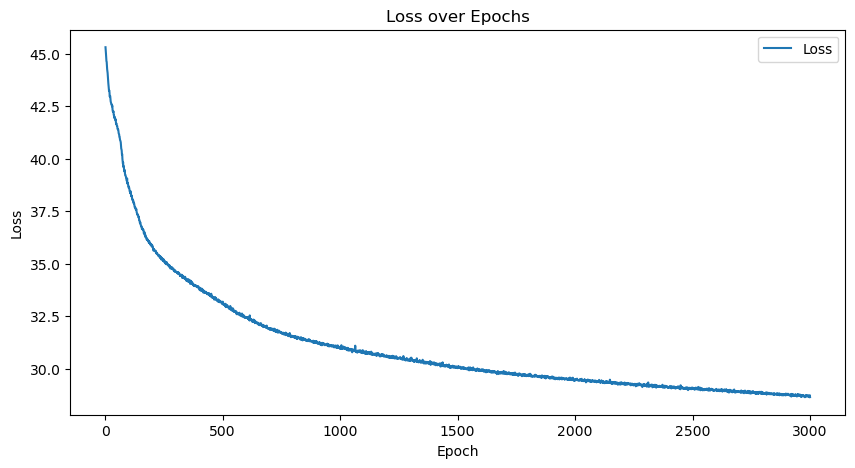

In [17]:
import matplotlib.pyplot as plt
import torch

# List to store loss values
loss_values = []

num_epochs = 3000
patience = 200  # Number of epochs to wait for improvement
best_loss = float('inf')
epochs_without_improvement = 0

# Path to save the best model
best_model_path = 'best_graph_vae_model.pth'

model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for data in dataloader:
        data = data.to(device)
        optimizer.zero_grad()

        # Forward pass
        recon, mu, logvar = model(data.x, data.edge_index, data.batch)

        # Reconstruction loss
        loss_recon = loss_function(recon.view(-1, data.num_nodes, data.num_node_features), data.x.view(-1, data.num_nodes, data.num_node_features))
        # KL divergence loss
        kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
        loss = loss_recon + beta * kld

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    loss_values.append(avg_loss)

    # Print the loss every 20 epochs
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch + 1}, Loss: {avg_loss}")

    # Check for improvement
    if avg_loss < best_loss:
        best_loss = avg_loss
        epochs_without_improvement = 0
        # Save the best model
        torch.save(model.state_dict(), best_model_path)
    else:
        epochs_without_improvement += 1

    # Early stopping
    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break

# Plot the loss values
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(loss_values) + 1), loss_values, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

In [18]:
# Check the columns and data types of the first DataFrame in the list
print("Columns and data types in the first DataFrame:")
print(encoded_autoencoder_input_dfs[0].dtypes)

print(encoded_autoencoder_input_dfs[0].head())# Identify non-numeric columns
non_numeric_columns = encoded_autoencoder_input_dfs[0].select_dtypes(exclude=['number']).columns
print("\nNon-numeric columns in the first DataFrame:")
print(non_numeric_columns)

Columns and data types in the first DataFrame:
X                    float64
Y                    float64
Z                    float64
Avg_Mass             float64
Avg_Neighbor_Dist    float64
Max_Neighbor_Dist    float64
Neighbor_Count       float64
AA_A                 float64
AA_C                 float64
AA_D                 float64
AA_E                 float64
AA_F                 float64
AA_G                 float64
AA_H                 float64
AA_I                 float64
AA_K                 float64
AA_L                 float64
AA_M                 float64
AA_N                 float64
AA_P                 float64
AA_Q                 float64
AA_R                 float64
AA_S                 float64
AA_T                 float64
AA_V                 float64
AA_W                 float64
AA_Y                 float64
dtype: object
        X       Y      Z   Avg_Mass  Avg_Neighbor_Dist  Max_Neighbor_Dist  \
0 -20.246  16.002 -8.805  149.20784           3.808177           3.808177   
1 

In [19]:
import pandas as pd

# Concatenate all DataFrames in the list
concatenated_df = pd.concat(encoded_autoencoder_input_dfs, ignore_index=True)

# Compute the mean and standard deviation
mean_values = concatenated_df.mean().values
std_values = concatenated_df.std().values

# Create the original_data_stats dictionary
original_data_stats = {'mean': mean_values, 'std': std_values}

print(original_data_stats)

{'mean': array([ 5.65913247e-02,  3.48543801e-01, -1.25179725e-01,  1.28955241e+02,
        3.90800645e+00,  4.05790675e+00,  2.25024111e+00,  7.96587186e-02,
        2.73541732e-02,  4.77573202e-02,  6.42673093e-02,  3.72297546e-02,
        7.12016714e-02,  2.19737415e-02,  4.89092284e-02,  6.48109767e-02,
        9.07986910e-02,  2.76228824e-02,  3.82733459e-02,  5.22753831e-02,
        4.03480304e-02,  5.74391811e-02,  7.29722355e-02,  5.34231252e-02,
        6.48338898e-02,  1.12795346e-02,  2.75708069e-02]), 'std': array([15.69205379, 11.27736496, 17.62370881, 28.05498225,  0.15494844,
        0.40165384,  0.56238103,  0.2707644 ,  0.16311339,  0.21325256,
        0.24522877,  0.18932452,  0.25716168,  0.14659789,  0.21567849,
        0.24619228,  0.28732292,  0.16388995,  0.19185561,  0.22258205,
        0.19677436,  0.23268011,  0.26009119,  0.22487597,  0.24623278,
        0.10560459,  0.16373977])}


### Generate New Graphs

In [25]:
from Utils import Utils
def generate_new_graphs(model, num_graphs, latent_dim, num_nodes, num_node_features, original_data_stats, distance_threshold=5.0):
    model.eval()  # Set the model to evaluation mode
    new_graphs = []

    with torch.no_grad():
        for _ in range(num_graphs):
            # Sample a random latent vector from a standard normal distribution
            z = torch.randn(1, latent_dim).to(device)

            # Decode the latent vector to generate a new graph
            recon = model.decode(z)

            # Convert the reconstructed features back to a PyTorch Geometric graph format
            x = recon.view(num_nodes, num_node_features)  # Ensure the correct shape
            # Scale the `x`, `y`, `z` coordinates back to the original range
            # i think this is only needed if i have normalised
            x[:, 0:3] = x[:, 0:3] * original_data_stats['std'][0:3] + original_data_stats['mean'][0:3]

            # Generate a realistic edge_index tensor based on the distance threshold
            edge_index = []
            coordinates = x[:, 0:3].cpu().numpy()
            for i in range(num_nodes):
                for j in range(i + 1, num_nodes):
                    dist = np.linalg.norm(coordinates[i] - coordinates[j])
                    if dist <= distance_threshold:
                        edge_index.append([i, j])
                        edge_index.append([j, i])

            edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

            new_graph = Data(x=x, edge_index=edge_index)
            new_graphs.append(new_graph)

    return new_graphs

# Generate 10 new protein graphs with specified dimensions
num_new_graphs = 10
latent_dim = out_channels  # Dimension of the latent space
num_nodes = 164  # Number of nodes obtained earlier in code
num_node_features = Utils.get_number_of_features()  # Number of node features
new_graphs = generate_new_graphs(model, num_new_graphs, latent_dim, num_nodes, num_node_features, original_data_stats)

# Print the number of nodes and edges in each generated graph
graph_creator.print_graphCollection_metrics(new_graphs)

Graph 1: 164 nodes, 4 edges, 27 features
Graph 2: 164 nodes, 8 edges, 27 features
Graph 3: 164 nodes, 34 edges, 27 features
Graph 4: 164 nodes, 24 edges, 27 features
Graph 5: 164 nodes, 8 edges, 27 features
Graph 6: 164 nodes, 50 edges, 27 features
Graph 7: 164 nodes, 16 edges, 27 features
Graph 8: 164 nodes, 18 edges, 27 features
Graph 9: 164 nodes, 12 edges, 27 features
Graph 10: 164 nodes, 6 edges, 27 features


In [26]:
# Print each node's features for the first graph
graph_creator.print_first_graph(new_graphs)

Node 1: tensor([-3.2416e+02, -1.3127e+02,  3.2706e+02,  2.9537e+01,  3.1871e+00,
         3.4153e+00,  7.5641e-01,  1.4335e-01, -3.5046e-02,  2.5079e-02,
        -8.6456e-02, -3.7934e-01,  2.7297e-01, -4.1697e-02,  5.9996e-02,
         6.5812e-02, -1.5911e-01,  9.1241e-01,  4.9277e-03,  1.1784e-02,
         3.1780e-02, -4.1186e-02,  3.0413e-01, -5.5353e-02, -5.5865e-02,
         3.1922e-03, -9.9895e-02])
Node 2: tensor([-3.1286e+02, -1.1941e+02,  3.0151e+02,  7.2420e+01,  3.3423e+00,
         3.0689e+00,  1.3576e+00,  2.9739e-01, -3.5080e-02, -1.9792e-02,
         3.5649e-01,  2.6916e-01,  3.1873e-01, -3.4074e-01,  2.1279e-01,
        -2.2336e-01, -3.3323e-01, -8.2453e-02,  2.6864e-01,  9.8461e-02,
        -3.9879e-02,  1.7795e-01,  6.4640e-02, -3.7870e-01, -3.9508e-01,
        -7.5002e-02,  1.6944e-01])
Node 3: tensor([-3.0487e+02, -1.1041e+02,  2.6766e+02,  5.9340e+01,  3.0867e+00,
         2.5767e+00,  1.4859e+00, -7.7175e-02, -2.1476e-01,  9.6929e-02,
         5.6149e-02, -1.2963e-

### Convert the `AA_` columns in the generated protein graphs to one-hot encoded format

In [27]:
# Convert the `AA_` columns in the generated protein graphs to one-hot encoded format
new_graphs = graph_creator.convert_graphs_to_one_hot(new_graphs)

In [28]:
# Print each node's features for the first graph
graph_creator.print_first_graph(new_graphs)

Node 1: tensor([-324.1570, -131.2734,  327.0578,   29.5369,    3.1871,    3.4153,
           0.7564,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
           0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    1.0000,
           0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
           0.0000,    0.0000,    0.0000])
Node 2: tensor([-312.8623, -119.4098,  301.5143,   72.4201,    3.3423,    3.0689,
           1.3576,    0.0000,    0.0000,    0.0000,    1.0000,    0.0000,
           0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
           0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
           0.0000,    0.0000,    0.0000])
Node 3: tensor([-304.8664, -110.4093,  267.6558,   59.3402,    3.0867,    2.5767,
           1.4859,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
           0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
           0.0000,    0.0000,    0.0000,    0.0000,    0.0000,    0.0000,
    

### Prune Small Subgraphs

In [29]:
# Example usage:
pruned_graphs = [graph_creator.prune_small_subgraphs(graph) for graph in new_graphs]

# Print the number of nodes and edges in each pruned graph
graph_creator.print_graphCollection_metrics(pruned_graphs)

Graph 1: 2 nodes, 2 edges, 27 features
Graph 2: 2 nodes, 2 edges, 27 features
Graph 3: 4 nodes, 8 edges, 27 features
Graph 4: 4 nodes, 8 edges, 27 features
Graph 5: 2 nodes, 2 edges, 27 features
Graph 6: 9 nodes, 28 edges, 27 features
Graph 7: 2 nodes, 2 edges, 27 features
Graph 8: 4 nodes, 6 edges, 27 features
Graph 9: 2 nodes, 2 edges, 27 features
Graph 10: 2 nodes, 2 edges, 27 features


### Print the Generated Protein Graphs

Number of nodes: 2
Number of edges: 2
Node features shape: torch.Size([2, 27])


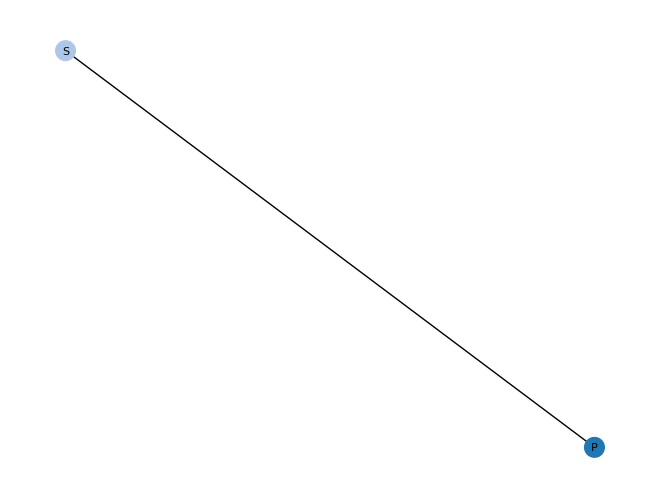

Number of nodes: 2
Number of edges: 2
Node features shape: torch.Size([2, 27])


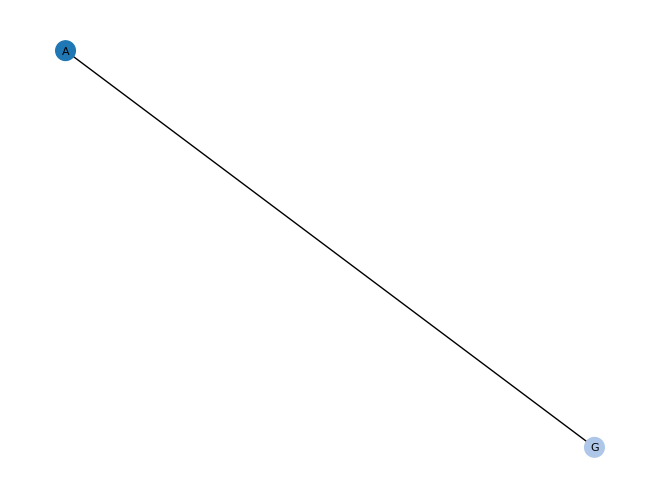

Number of nodes: 4
Number of edges: 8
Node features shape: torch.Size([4, 27])


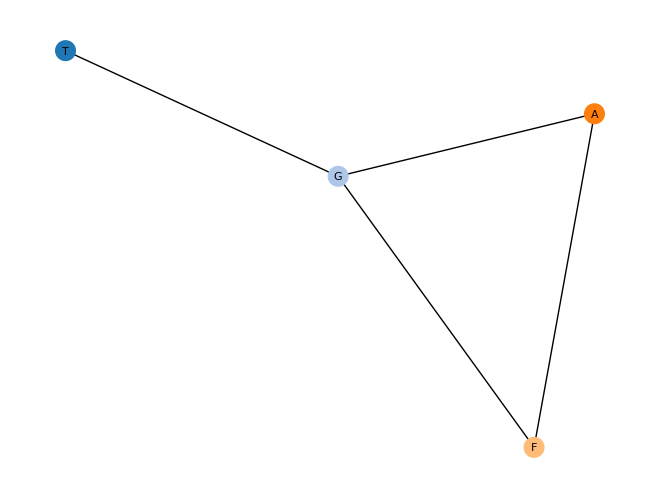

Number of nodes: 4
Number of edges: 8
Node features shape: torch.Size([4, 27])


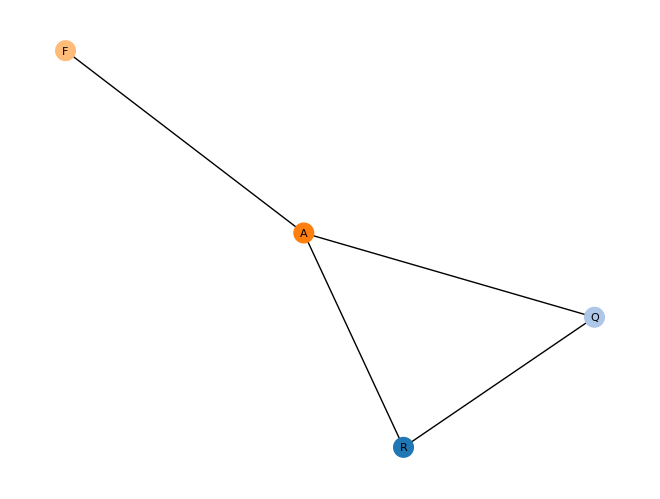

Number of nodes: 2
Number of edges: 2
Node features shape: torch.Size([2, 27])


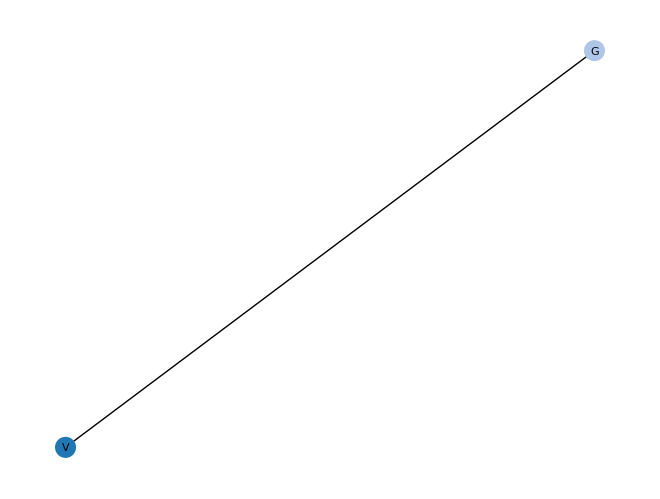

Number of nodes: 9
Number of edges: 28
Node features shape: torch.Size([9, 27])


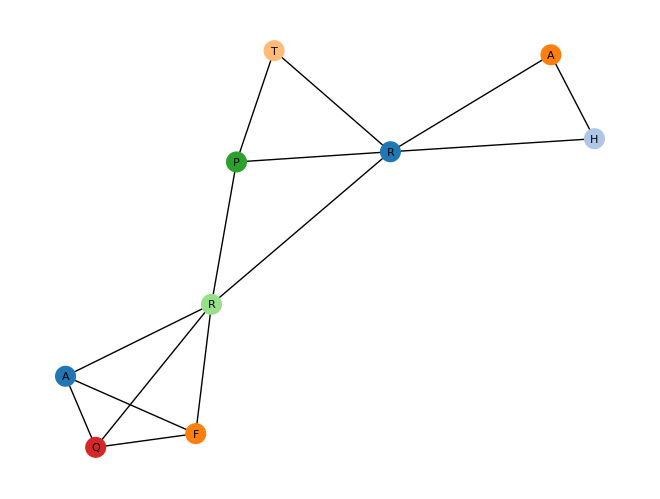

Number of nodes: 2
Number of edges: 2
Node features shape: torch.Size([2, 27])


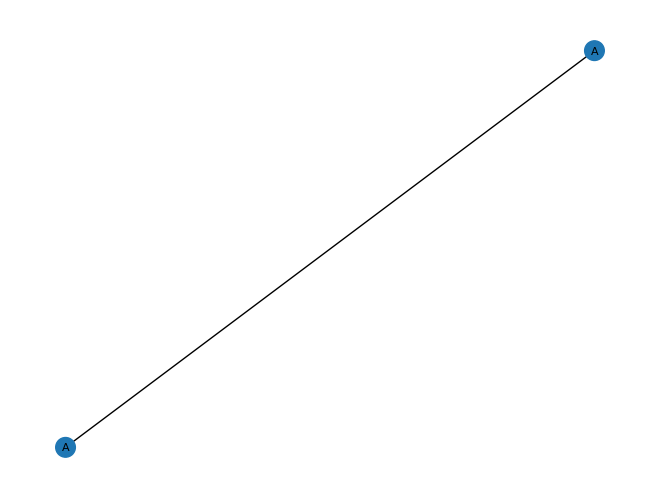

Number of nodes: 4
Number of edges: 6
Node features shape: torch.Size([4, 27])


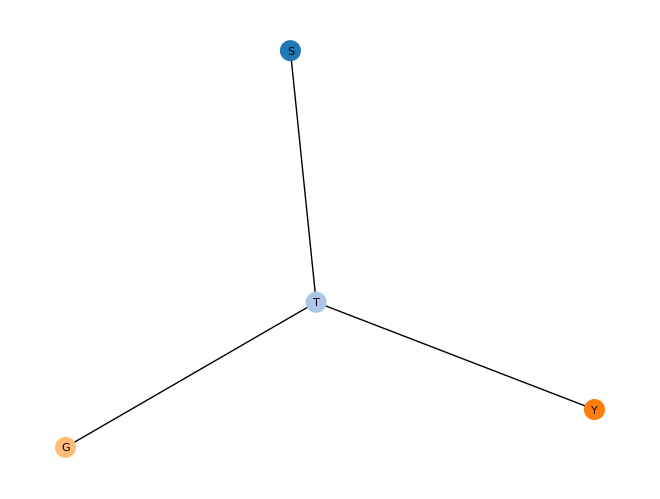

Number of nodes: 2
Number of edges: 2
Node features shape: torch.Size([2, 27])


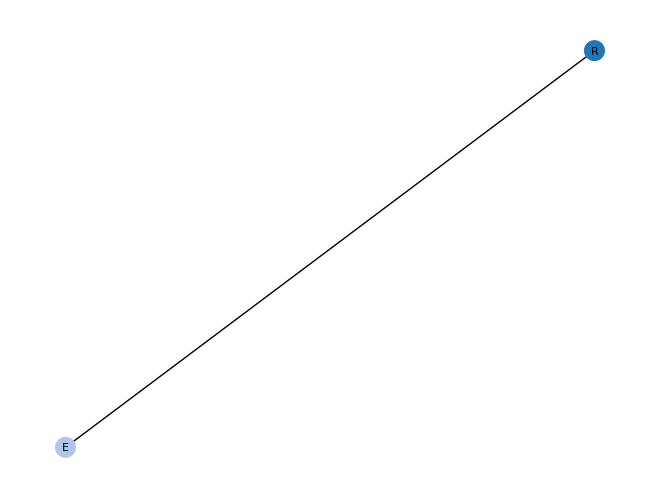

Number of nodes: 2
Number of edges: 2
Node features shape: torch.Size([2, 27])


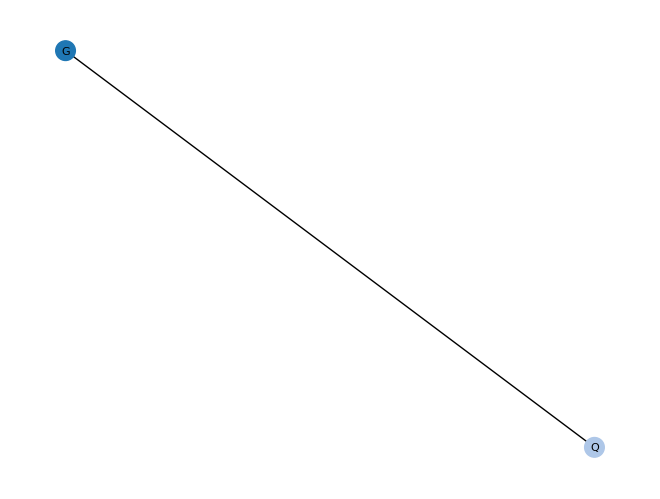

In [30]:
for i, graph in enumerate(pruned_graphs):
    graph_creator.print_graph_metrics(graph)
    graph_creator.draw_graph(graph, onehot_encoder)

In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_protein_structure(graph, le, aa_info_dict):
    # Define color mapping for amino acids
    color_map = {
        'A': 'blue', 'C': 'cyan', 'D': 'purple', 'E': 'pink', 'F': 'orange',
        'G': 'green', 'H': 'red', 'I': 'yellow', 'K': 'violet', 'L': 'brown',
        'M': 'grey', 'N': 'lightblue', 'O': 'lightgreen', 'P': 'coral', 'Q': 'olive',
        'R': 'gold', 'S': 'navy', 'T': 'teal', 'U': 'maroon', 'V': 'lime',
        'W': 'magenta', 'Y': 'darkorange'
    }

    # Extract coordinates and additional info
    coords = graph.x[:, :3].numpy()  # Assuming the first three columns are X, Y, Z coordinates
    aa_indices = graph.x[:, 3].numpy()  # Assuming the fourth column is the encoded amino acid index
    masses = graph.x[:, 4].numpy()  # Assuming the fifth column is the mass

    # Decode amino acid indices to letters
    aa_letters = le.inverse_transform(aa_indices.astype(int))

    # Normalize masses for sphere sizes, increase scaling for larger spheres
    normalized_sizes = (masses - masses.min()) / (masses.max() - masses.min()) * 200 + 20

    # Plot in 3D
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Plot each C-alpha as a sphere
    for i, (x, y, z, aa, mass) in enumerate(zip(coords[:, 0], coords[:, 1], coords[:, 2], aa_letters, normalized_sizes)):
        ax.scatter(x, y, z, s=mass, c=color_map.get(aa, 'black'))

    # Add a legend with full amino acid names using dummy points
    for aa, color in color_map.items():
        full_name = aa_info_dict.get(aa, 'Unknown')
        ax.scatter([], [], [], color=color, label=full_name)  # Dummy points for legend

    # Customize plot appearance
    ax.set_title("3D Protein Structure with C-alpha Spheres")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.legend(title="Amino Acids", loc="upper left", bbox_to_anchor=(1, 1), markerscale=1.2)
    plt.show()

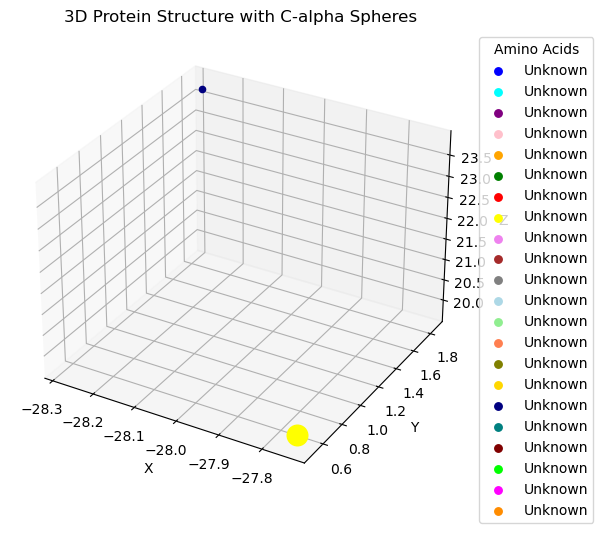

In [24]:
aa_info = pd.read_csv('aa_mass_letter.csv')
aa_info_dict = aa_info.set_index('Abbrev.').to_dict(orient='index')

plot_protein_structure(graph, le, aa_info_dict)